In [26]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from tqdm.notebook import tqdm
from astropy.io import fits
import MegaScreen
import numpy as onp
import pickle

In [2]:
import jax
import jax.numpy as np
from jax import jit, value_and_grad
from jax.ops import index, index_update

In [3]:
def get_power_spectrum(image):
    return np.abs(np.fft.fftshift(np.fft.fft2(image)))**2

def get_log10_power_spectrum(image):
    return np.log10(get_power_spectrum(image))

def get_FF_err(X, FF_true, npix, r_mask=None):
    FF_inv = X.reshape([npix, npix])    
    FF_new = 1/FF_inv
    FF_residual = FF_true - FF_new
    
    if r_mask is not None:
        R = get_radial(npix)
        FF_residual = index_update(FF_residual, index[R>r_mask], 0)
        
    FF_err = np.sum(np.abs(FF_residual))
    return FF_residual, FF_err

def get_radial(npix):
    c = npix//2
    xrange = np.arange(-c, c)
    X, Y = np.meshgrid(xrange, xrange)
    R = np.hypot(X, Y)
    return R

def get_outer_sum(array, r):
    R = get_radial(array.shape[0])
    sum_out = np.sum(array[R > r])
    return sum_out

def get_PSF(phase_array, padding=2):
    
    arr_size = phase_array.shape[0]
    pad_size = np.round(padding * arr_size, decimals=0)
    
    array_out = np.zeros((pad_size, pad_size))
    array_out = index_update(array_out, index[0:arr_size, 0:arr_size], phase_array)
    
    # Perform FT
    PSF = np.abs(np.fft.fftshift(np.fft.fft2(array_out)))**2
    PSF_norm = PSF/np.sum(PSF)    
    
    return PSF_norm

def get_spectrums(images):
    """
    Inputs
        images: a list or array of images
        Note this has not been written to handle arbitrary array dimensions
    Outputs:
        images: The original images
        power_specturms: power specturms of the images
        mean_power_specturm: Mean of the power spectrums
        mean_image: Mean of all the images
        mean_image_power_spectrum: power specturm of the mean image
    """
    # Get power spectrums
    power_spectrums = get_power_spectrum(images)

    # Get mean power spectrum
    mean_power_spectrum = np.mean(power_spectrums, axis=0)

    # Get mean image
    mean_image = np.mean(images, axis=0)

    # Get mean image power spectrum
    mean_image_power_spectrum = get_power_spectrum(mean_image)
    
    return [images, power_spectrums, mean_power_spectrum, mean_image, mean_image_power_spectrum]

def ADAM(X, grad, LR, i, m, v, b1=0.9, b2=0.999, epsilon=1):
    m = b1 * m + (1 - b1) * grad
    v = b2 * v + (1 - b2) * np.power(grad, 2)
    m_hat = m / (1 - np.power(b1, i+1))
    v_hat = v / (1 - np.power(b2, i+1))
    X_new = X - LR * m_hat / (np.sqrt(v_hat) + epsilon)
    return X_new, m, v

def get_power_spec_min(image):
    return np.abs(np.fft.fftshift(np.fft.fft2(image)))**2
get_power_spec = jit(get_power_spec_min)


def error(X, images, r=None):
    npix = 256
    
    # Get Radial values and frequncy mask
    xrange = np.arange(-npix//2, npix//2)
    Xs, Ys = np.meshgrid(xrange, xrange)
    R = np.hypot(Xs, Ys)
    freq_mask = R > r
    
    # Apply bounds 
    X = np.maximum(X, 1) # Apply Floor
    
    # Reshape X into a square
    FF_inv = X.reshape([npix, npix])
    
    # Apply FF correction to images
    corrected_images = FF_inv * images
    
    # Get the power spectrum of all the images
    images_power_spec = get_power_spec(corrected_images)

    # Apply the frequency mask
    masked_images = freq_mask * images_power_spec
    
    # Get sum of frequncies above the diffraction limit
    power_spec_outer_sum = np.sum(masked_images)

    return power_spec_outer_sum

err_grad = value_and_grad(error, argnums=0)

In [4]:
seed = 0
nimages = 250
npix = 256
padding = 2
aperture_size = np.round(npix/padding, decimals=0).astype(np.int16)
total_flux = 1e6
BG_stdev = 5 
FF_range = 0.2

/suphys/ldes9555/anaconda3/envs/main/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
generator = MegaScreen.MegaScreen(windowShape=(aperture_size, aperture_size), dx=1e3)
BG_noise = np.abs(onp.random.normal(loc=0, scale=BG_stdev, size=[nimages, npix, npix]))
FF = 1 - (FF_range * onp.random.rand(npix**2).reshape([npix, npix]))
xs = np.arange(-aperture_size//2, aperture_size//2)
Xs, Ys = np.meshgrid(xs, xs)
magnitude = index_update(np.ones([aperture_size, aperture_size]), index[np.hypot(Xs, Ys) >= aperture_size//2], 0)

In [6]:
# Make noisy pupils
rand_pupils = []
for rand_phase in range(nimages):
    rand_pupils.append(magnitude * np.exp(1j * next(generator)))

In [7]:
PSFs = []

for i in range(len(rand_pupils)):
    PSFs.append(total_flux * get_PSF(rand_pupils[i]))

PSFs = np.array(PSFs)

/suphys/ldes9555/anaconda3/envs/main/lib/python3.8/site-packages/jax/ops/scatter.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax.convert_element_type(out, dtype)


In [8]:
%%time

images_FF = PSFs * FF
images_FF_photon = onp.random.poisson(PSFs * FF)
images_FF_BG = (PSFs * FF) + BG_noise
images_FF_photon_BG = (onp.random.poisson(PSFs) * FF) + BG_noise

images_all = np.array([PSFs, images_FF, images_FF_photon, images_FF_BG, images_FF_photon_BG])
titles = ["Pure PSFs", "No Noise", "Photon noise", "BG Noise", "BG & Photon Noise"]

spectrums = []
for i in range(len(images_all)):
    spectrums.append(get_spectrums(images_all[i]))

CPU times: user 11.3 s, sys: 926 ms, total: 12.3 s
Wall time: 11.2 s


---

## Lets plot things

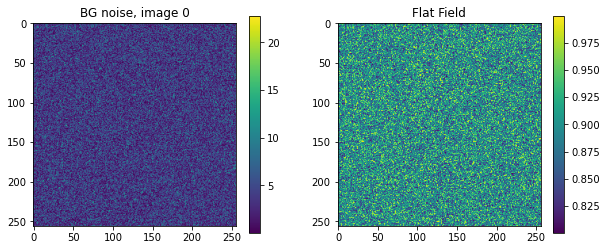

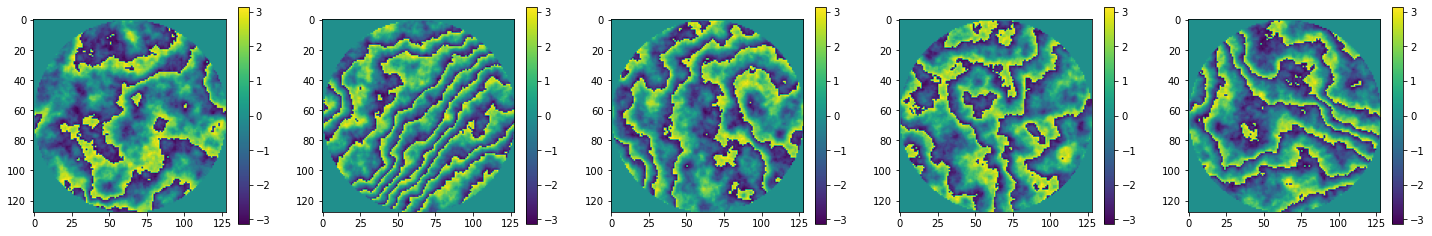

In [10]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(BG_noise[0])
plt.title("BG noise, image 0")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(FF)
plt.title("Flat Field")
plt.colorbar()

plt.show()

plt.figure(figsize=(25, 4))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.abs(rand_pupils[i])*np.angle(rand_pupils[i]))
    plt.colorbar()
    
plt.show()

---

## Now lets plot more things!



Pure PSFs


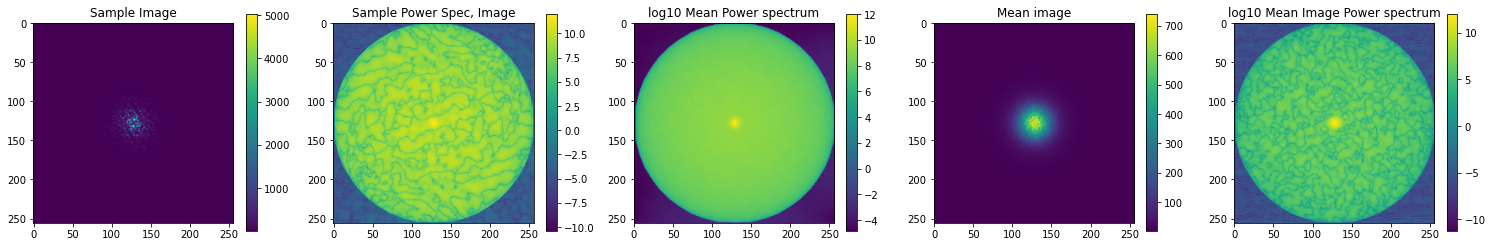



No Noise


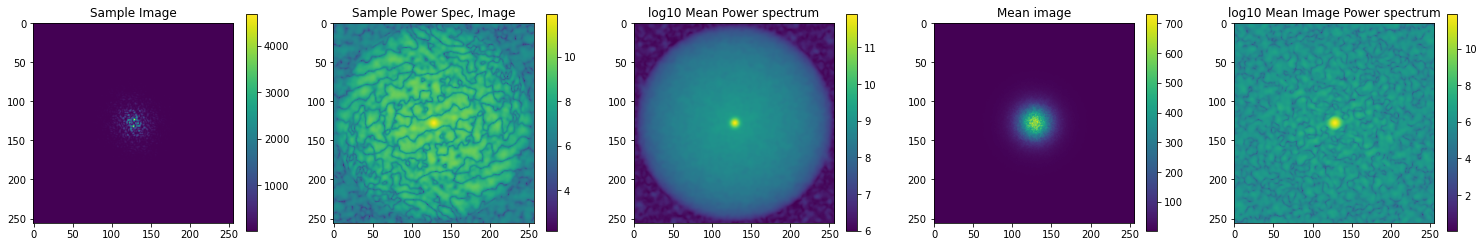



Photon noise


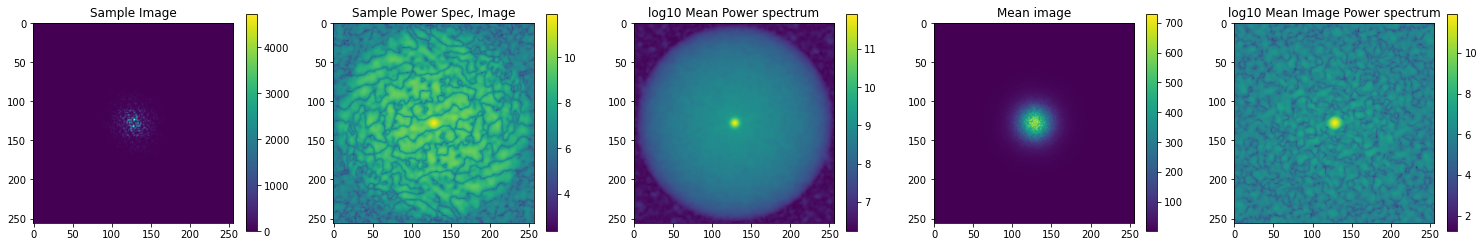



BG Noise


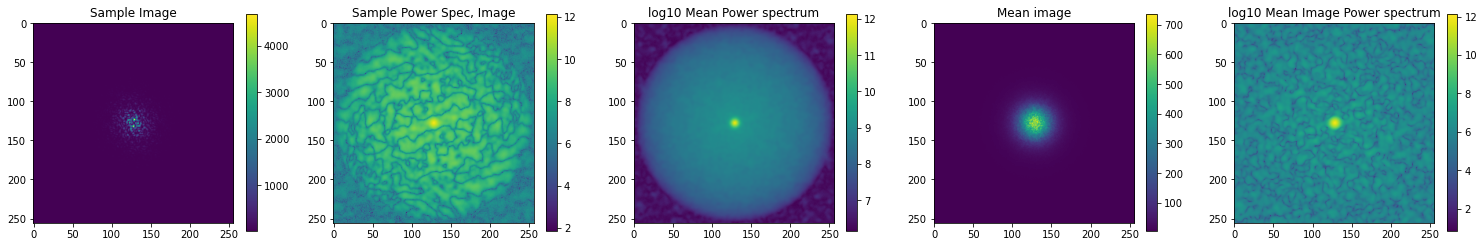



BG & Photon Noise


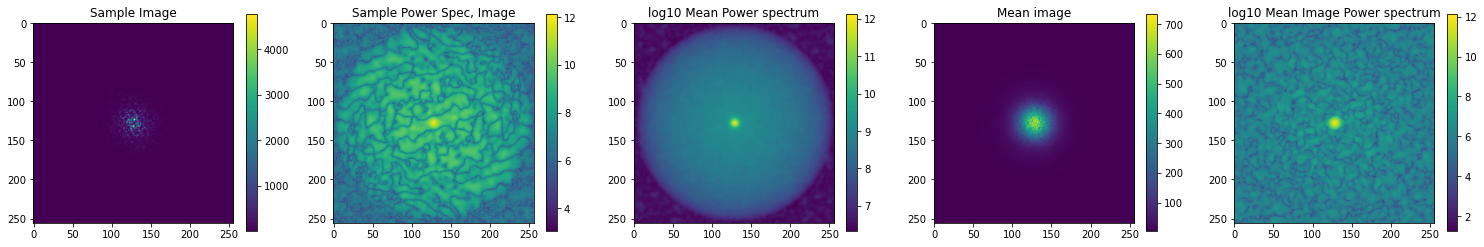

In [11]:
for i in range(len(images_all)):
    print("\n\n{}".format(titles[i]))
    plt.figure(figsize=(26, 4))

    plt.subplot(1, 5, 1)
    plt.imshow(spectrums[i][0][0])
    plt.title("Sample Image")
    plt.colorbar()

    plt.subplot(1, 5, 2)
    plt.imshow(np.log10(spectrums[i][1][0]))
    plt.title("Sample Power Spec, Image")
    plt.colorbar()

    plt.subplot(1, 5, 3)
    plt.title("log10 Mean Power spectrum")
    plt.imshow(np.log10(spectrums[i][2]))
    plt.colorbar()

    plt.subplot(1, 5, 4)
    plt.title("Mean image")
    plt.imshow(spectrums[i][3])
    plt.colorbar()

    plt.subplot(1, 5, 5)
    plt.title("log10 Mean Image Power spectrum")
    plt.imshow(np.log10(spectrums[i][4]))
    plt.colorbar()

    plt.show()

---

## Now try all the different permutations of noise sources

In [12]:
# Take a safe radius
r = 130

In [13]:
errs_out = []
Xs_out = []

for j in tqdm(range(len(images_all))):
# for j in [1]:
    images = images_all[j]
    
    X = 1.1*np.ones(npix**2)
    LR = 1e-2
    m, v = 0, 0

    errs = []
    Xs = []
    epochs = [50, 100]
    for i in tqdm(range(epochs[-1]), leave=False):

        # Reduce LR 
        if i in epochs:
            LR *= 0.1

        # Get gradients and update X
        err, grads = err_grad(X, images, r=r)
        errs.append(err)
        Xs.append(X)
        X, m, v = ADAM(X, grads, LR, i, m, v)

        # Apply bounds 
        X = np.maximum(X, 1) # Apply Floor

    errs_out.append(errs)
    Xs_out.append(Xs)

errs_out = onp.array(errs_out)
errs_out = np.array(errs_out)

Xs_out = onp.array(Xs_out)
Xs_out = np.array(Xs_out)

In [21]:
# # Save
# with open("files/errs_out_speckle_test.pkl", 'wb') as f:
#     pickle.dump(errs_out, f)
    
# with open("files/Xs_out_speckle_test.pkl", 'wb') as f:
#     pickle.dump(Xs_out, f)
       
# Load
# with open("files/errs_out_speckle_test.pkl", 'rb') as f:
#     errs_out = pickle.load(f)
    
# with open("files/Xs_out_speckle_test.pkl", 'rb') as f:
#     Xs_out = pickle.load(f)

In [28]:
r_mask = 40
FF_errs = []
for i in tqdm(range(len(images_all))):
    FF_errs_temp = []
    for j in range(len(Xs)):
        FF_res, FF_err = get_FF_err(Xs_out[i, j], FF, npix, r_mask=r_mask)
        FF_errs_temp.append(FF_err)
    FF_errs.append(FF_errs_temp)

# FF_errs = []
# for j in range(len(Xs)):
#     FF_errs.append(get_FF_err(Xs[j], FF, npix, r_mask=20)[1])

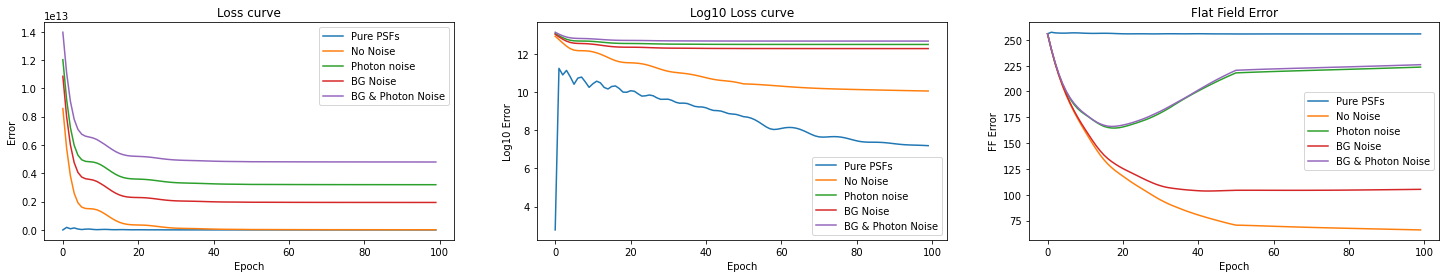

In [33]:
plt.figure(figsize=(25, 4))

plt.subplot(1, 3, 1)
for i in range(len(errs_out)):
    plt.plot(errs_out[i], label="{}".format(titles[i]))
plt.legend()
plt.title("Loss curve")
plt.ylabel("Error")
plt.xlabel("Epoch")

plt.subplot(1, 3, 2)
for i in range(len(errs_out)):
    plt.plot(onp.log10(errs_out[i]), label="{}".format(titles[i]))
plt.legend()
plt.title("Log10 Loss curve")
plt.ylabel("Log10 Error")
plt.xlabel("Epoch")

plt.subplot(1, 3, 3)
for i in range(len(errs_out)):
    plt.plot(FF_errs[i], label="{}".format(titles[i]))
plt.legend()
plt.title("Flat Field Error")
plt.ylabel("FF Error")
plt.xlabel("Epoch")

plt.show()

In [30]:
Xs_final = Xs_out[:, -1, :]
FFs_final = 1/Xs_final.reshape([len(images_all), npix, npix])

FFs_final_zeroed = np.abs(1 - FFs_final)
FF_power_specs = get_power_spec(FFs_final)

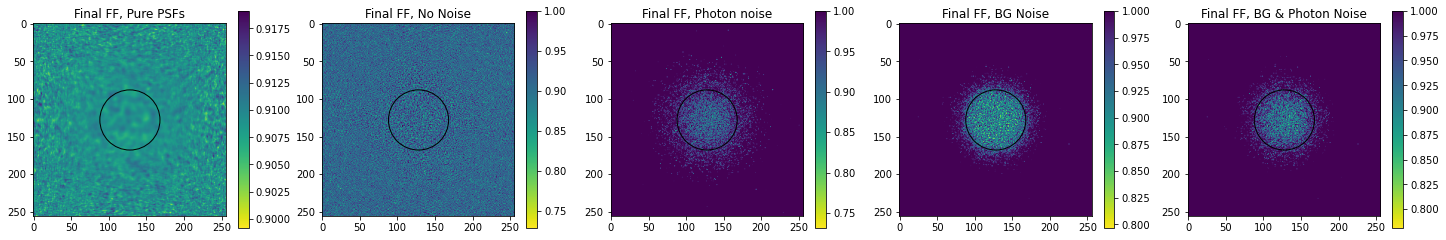

In [31]:
plt.figure(figsize=(25, 4))

for i in range(len(images_all)):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(FFs_final[i], cmap='viridis_r')
    ax.add_artist(Circle((npix//2, npix//2), radius=r_mask, fill=False))
    plt.title("Final FF, {}".format(titles[i]))
    plt.colorbar()
    
plt.show()

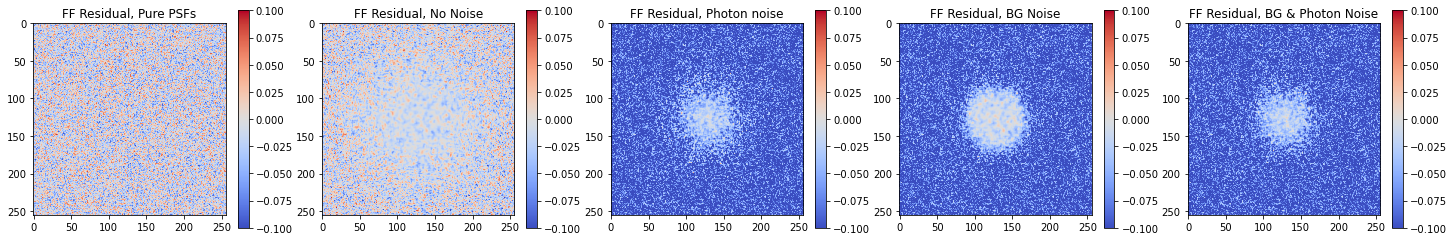

In [32]:
plt.figure(figsize=(25, 4))

for i in range(len(images_all)):
    plt.subplot(1, 5, i+1)
    plt.imshow(FF - FFs_final[i], cmap='coolwarm', vmin=-0.1, vmax=0.1)
    plt.title("FF Residual, {}".format(titles[i]))
    plt.colorbar()
    
plt.show()

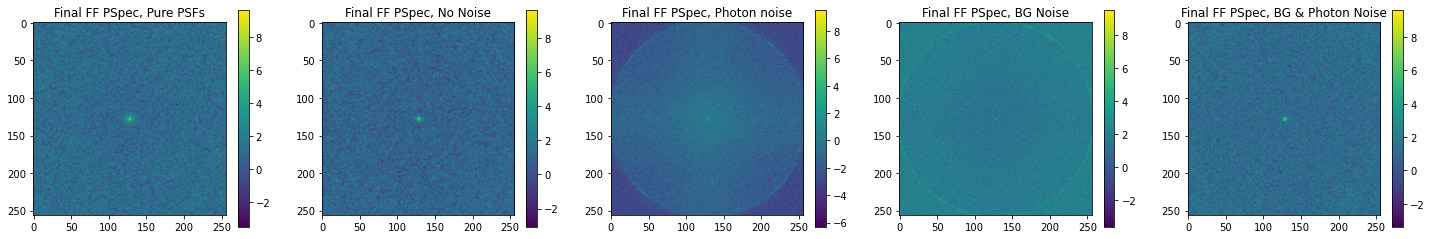

In [20]:
plt.figure(figsize=(25, 4))

for i in range(len(images_all)):

    plt.subplot(1, 5, i+1)
    plt.imshow(np.log10(FF_power_specs[i]))
    plt.title("Final FF PSpec, {}".format(titles[i]))
    plt.colorbar()
    
plt.show()